In [1]:
import torch
import torch.nn as nn
from alexnet_model import Alexnet
from torchvision.transforms import transforms
from torchvision import datasets
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


# tensorboard --logdir=runs

In [2]:
# device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Using Pretrained Custom Alexnet for Transfer Learning

## Loading the Saved Model

In [19]:
alexnet=Alexnet()
alexnet.to(device)
alexnet.load_state_dict(torch.load('alexnetr.pt'))

<All keys matched successfully>

## Preparing the Dataloaders

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((227,227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Freezing all the Layers except the Last Two Fully Connected layer

In [22]:
for params in alexnet.parameters():
    params.requires_grad=False


alexnet.model[20]=nn.Linear(in_features=4096,out_features=2)
alexnet.model[18]=nn.Linear(in_features=4096,out_features=4096)
alexnet.to(device)

Alexnet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True)
    (17): Dropout(p=0.5, inplace=False)
    (1

## Finetuning the Model

In [7]:
optim= torch.optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
loss_train=[]
loss_test=[]
acc_train=[]
acc_test=[]


In [8]:
for epoch in range(50):
    running_loss=0
    count=0
    train_accuracy=0
    trunning_lost=0
    tcount=0
    val_accuracy=0

    for idx,data in enumerate(dataloaders['train']):
        count+=1
        optim.zero_grad()

        img,label=data
        logits=alexnet(img.to(device))

        loss=(torch.nn.functional.cross_entropy(logits,label.to(device)))

        loss.backward()
        optim.step()

        running_loss+=loss
        train_accuracy+=(torch.sum(torch.where(logits.argmax(1)==label.to(device), 1, 0)))

    with torch.no_grad():
      for t_idx,t_data in enumerate(dataloaders['val']):
        tcount+=1
        timg,tlabel=t_data
        t_logits=alexnet(timg.to(device))
        tloss=(torch.nn.functional.cross_entropy(t_logits,tlabel.to(device)))

        trunning_lost+=tloss
        val_accuracy+=(torch.sum(torch.where(t_logits.argmax(1)==tlabel.to(device), 1, 0)))


    # adding losses to the list
    loss_train.append((running_loss/count).item())
    loss_test.append((trunning_lost/tcount).item())

    # adding accuracy values to the list
    acc_train.append((train_accuracy/dataset_sizes['train']).item())
    acc_test.append((val_accuracy/dataset_sizes['val']).item())

    print(f'Epoch: {epoch} | Training Loss: {(running_loss/count): .3f} | Train-Accuracy: {train_accuracy/dataset_sizes['train']: .3f} \
           Validation Loss: {(trunning_lost/tcount): .3f} | Validation Accuracy: {val_accuracy/dataset_sizes['val']: .3f}')
    


Epoch: 0 | Training Loss:  0.692 | Train-Accuracy:  0.541            Validation Loss:  0.694 | Validation Accuracy:  0.510
Epoch: 1 | Training Loss:  0.690 | Train-Accuracy:  0.525            Validation Loss:  0.689 | Validation Accuracy:  0.549
Epoch: 2 | Training Loss:  0.693 | Train-Accuracy:  0.475            Validation Loss:  0.695 | Validation Accuracy:  0.510
Epoch: 3 | Training Loss:  0.688 | Train-Accuracy:  0.549            Validation Loss:  0.691 | Validation Accuracy:  0.497
Epoch: 4 | Training Loss:  0.684 | Train-Accuracy:  0.557            Validation Loss:  0.687 | Validation Accuracy:  0.523
Epoch: 5 | Training Loss:  0.687 | Train-Accuracy:  0.561            Validation Loss:  0.678 | Validation Accuracy:  0.588
Epoch: 6 | Training Loss:  0.684 | Train-Accuracy:  0.553            Validation Loss:  0.685 | Validation Accuracy:  0.549
Epoch: 7 | Training Loss:  0.682 | Train-Accuracy:  0.545            Validation Loss:  0.680 | Validation Accuracy:  0.582
Epoch: 8 | Train

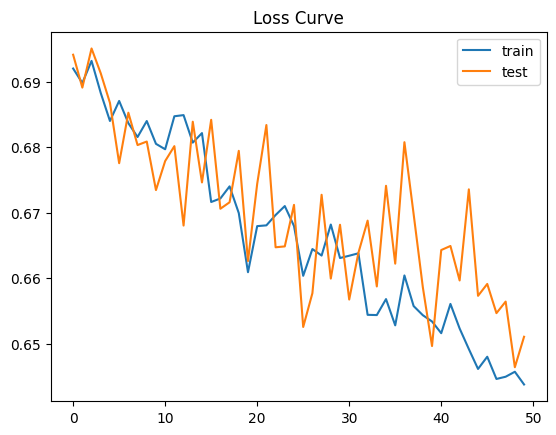

In [9]:
plt.plot(loss_train,label="train")
plt.plot(loss_test,label='test')
plt.title("Loss Curve")
plt.legend()
plt.show()

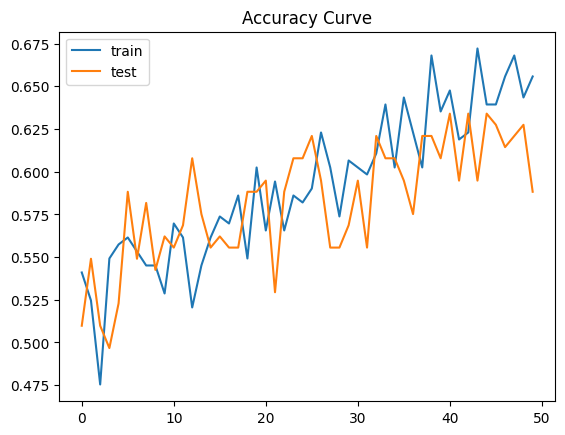

In [10]:
plt.plot(acc_train,label="train")
plt.plot(acc_test,label='test')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

In [21]:
import numpy as np

In [20]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

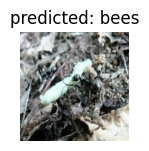

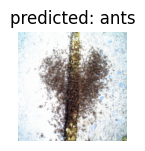

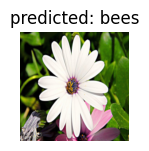

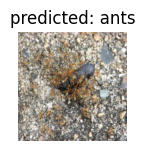

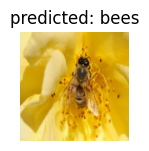

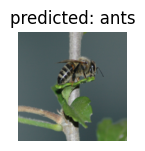

In [14]:
visualize_model(alexnet)

plt.ioff()
plt.show()

# Now Using Pretrained Model from Torchvision for Transfer Learning

In [3]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights=Inception_V3_Weights.DEFAULT
inc_model = inception_v3(weights=weights)
# preprocess = weights.transforms()

# Apply it to the input image
# img_transformed = preprocess(img)

## Data Preparation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Freezing all the Layers except the Fully Connected Layer

In [5]:
for params in inc_model.parameters():
    params.requires_grad=False

inc_model.fc=nn.Linear(in_features=2048,out_features=2)
inc_model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## Finetuning the Model

In [6]:
optim= torch.optim.SGD(inc_model.parameters(), lr=0.001, momentum=0.9)
loss_train=[]
loss_test=[]
acc_train=[]
acc_test=[]

In [7]:
for epoch in range(50):
    running_loss=0
    count=0
    train_accuracy=0
    trunning_lost=0
    tcount=0
    val_accuracy=0

    for idx,data in enumerate(dataloaders['train']):
        count+=1
        optim.zero_grad()

        img,label=data
        logits,_=inc_model(img.to(device))

        loss=(torch.nn.functional.cross_entropy(logits,label.to(device)))

        loss.backward()
        optim.step()

        running_loss+=loss
        train_accuracy+=(torch.sum(torch.where(logits.argmax(1)==label.to(device), 1, 0)))

    with torch.no_grad():
      for t_idx,t_data in enumerate(dataloaders['val']):
        tcount+=1
        timg,tlabel=t_data
        t_logits,_=inc_model(timg.to(device))
        tloss=(torch.nn.functional.cross_entropy(t_logits,tlabel.to(device)))

        trunning_lost+=tloss
        val_accuracy+=(torch.sum(torch.where(t_logits.argmax(1)==tlabel.to(device), 1, 0)))


    # adding losses to the list
    loss_train.append((running_loss/count).item())
    loss_test.append((trunning_lost/tcount).item())

    # adding accuracy values to the list
    acc_train.append((train_accuracy/dataset_sizes['train']).item())
    acc_test.append((val_accuracy/dataset_sizes['val']).item())

    # writer1.add_scalars('Loss Curve',{'Train':(running_loss/count).item(),
    #                                 'Validation': (trunning_lost/tcount).item()},epoch)
    
    # writer2.add_scalars('Accuracy Curve',{'Train':(train_accuracy/dataset_sizes['train']).item(),
    #                             'Validation': (val_accuracy/dataset_sizes['val']).item()},epoch)

    print(f'Epoch: {epoch} | Training Loss: {(running_loss/count): .3f} | Train-Accuracy: {train_accuracy/dataset_sizes['train']: .3f} \
           Validation Loss: {(trunning_lost/tcount): .3f} | Validation Accuracy: {val_accuracy/dataset_sizes['val']: .3f}')
    
# writer1.close()
# writer2.close()


Epoch: 0 | Training Loss:  0.733 | Train-Accuracy:  0.455            Validation Loss:  0.698 | Validation Accuracy:  0.523
Epoch: 1 | Training Loss:  0.698 | Train-Accuracy:  0.525            Validation Loss:  0.700 | Validation Accuracy:  0.542
Epoch: 2 | Training Loss:  0.649 | Train-Accuracy:  0.623            Validation Loss:  0.641 | Validation Accuracy:  0.654
Epoch: 3 | Training Loss:  0.622 | Train-Accuracy:  0.676            Validation Loss:  0.588 | Validation Accuracy:  0.739
Epoch: 4 | Training Loss:  0.562 | Train-Accuracy:  0.750            Validation Loss:  0.544 | Validation Accuracy:  0.791
Epoch: 5 | Training Loss:  0.519 | Train-Accuracy:  0.832            Validation Loss:  0.519 | Validation Accuracy:  0.837
Epoch: 6 | Training Loss:  0.481 | Train-Accuracy:  0.844            Validation Loss:  0.508 | Validation Accuracy:  0.882
Epoch: 7 | Training Loss:  0.455 | Train-Accuracy:  0.881            Validation Loss:  0.471 | Validation Accuracy:  0.869
Epoch: 8 | Train

KeyboardInterrupt: 

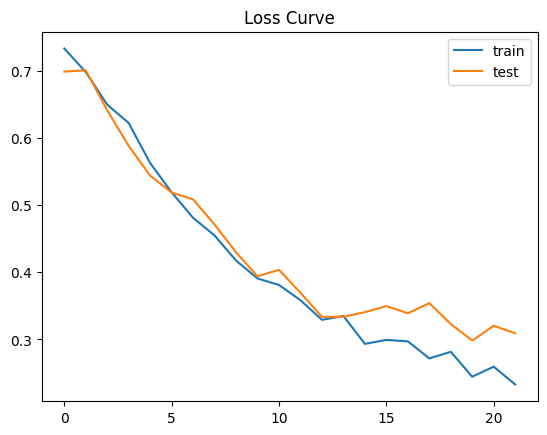

In [8]:
plt.plot(loss_train,label="train")
plt.plot(loss_test,label='test')
plt.title("Loss Curve")
plt.legend()
plt.show()

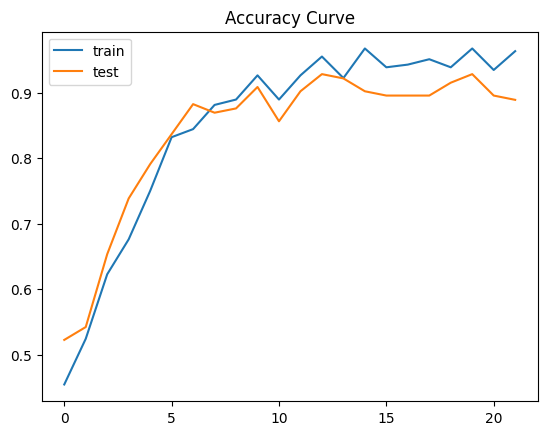

In [9]:
plt.plot(acc_train,label="train")
plt.plot(acc_test,label='test')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

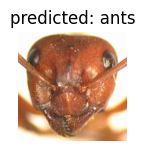

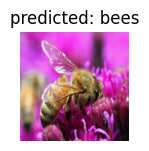

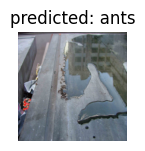

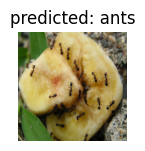

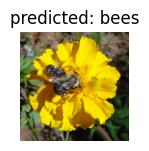

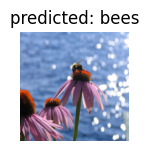

In [13]:
visualize_model(inc_model)

plt.ioff()
plt.show()

# Using Pretrained model from the huggingface for finetuning

In [3]:
import torch.nn as nn
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch

/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading Pretrained Model- (Resnet-50)

In [4]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
hmodel = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


hmodel.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

## Freezing all the Layers Except the Last Fully Connected Layer

In [5]:
for params in hmodel.parameters():
  params.requires_grad=False

hmodel.classifier[1]=nn.Linear(in_features=2048,out_features=2)
hmodel.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

## Preparing Data

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Finetuning the Model

In [12]:
optim= torch.optim.SGD(hmodel.parameters(), lr=0.001, momentum=0.9)
loss_train=[]
loss_test=[]
acc_train=[]
acc_test=[]

In [14]:
for epoch in range(20):
    running_loss=0
    count=0
    train_accuracy=0
    trunning_lost=0
    tcount=0
    val_accuracy=0

    for idx,data in enumerate(dataloaders['train']):
        count+=1
        optim.zero_grad()

        img,label=data
        inputs = processor(img.to(device), return_tensors="pt",do_rescale=False)
        logits = hmodel(**inputs.to(device)).logits

        loss=(torch.nn.functional.cross_entropy(logits,label.to(device)))

        loss.backward()
        optim.step()

        running_loss+=loss
        train_accuracy+=(torch.sum(torch.where(logits.argmax(1)==label.to(device), 1, 0)))

    with torch.no_grad():
      for t_idx,t_data in enumerate(dataloaders['val']):
        tcount+=1
        timg,tlabel=t_data
        tinputs = processor(timg.to(device), return_tensors="pt",do_rescale=False)
        t_logits = hmodel(**tinputs.to(device)).logits
        tloss=(torch.nn.functional.cross_entropy(t_logits,tlabel.to(device)))

        trunning_lost+=tloss
        val_accuracy+=(torch.sum(torch.where(t_logits.argmax(1)==tlabel.to(device), 1, 0)))


    # adding losses to the list
    loss_train.append((running_loss/count).item())
    loss_test.append((trunning_lost/tcount).item())

    # adding accuracy values to the list
    acc_train.append((train_accuracy/dataset_sizes['train']).item())
    acc_test.append((val_accuracy/dataset_sizes['val']).item())

    print(f'Epoch: {epoch} | Training Loss: {(running_loss/count): .3f} | Train-Accuracy: {train_accuracy/dataset_sizes['train']: .3f} \
           Validation Loss: {(trunning_lost/tcount): .3f} | Validation Accuracy: {val_accuracy/dataset_sizes['val']: .3f}')
    


Epoch: 0 | Training Loss:  0.699 | Train-Accuracy:  0.475            Validation Loss:  0.681 | Validation Accuracy:  0.608
Epoch: 1 | Training Loss:  0.673 | Train-Accuracy:  0.680            Validation Loss:  0.646 | Validation Accuracy:  0.837
Epoch: 2 | Training Loss:  0.633 | Train-Accuracy:  0.930            Validation Loss:  0.611 | Validation Accuracy:  0.895
Epoch: 3 | Training Loss:  0.586 | Train-Accuracy:  0.959            Validation Loss:  0.561 | Validation Accuracy:  0.928
Epoch: 4 | Training Loss:  0.539 | Train-Accuracy:  0.963            Validation Loss:  0.523 | Validation Accuracy:  0.928
Epoch: 5 | Training Loss:  0.495 | Train-Accuracy:  0.975            Validation Loss:  0.481 | Validation Accuracy:  0.948
Epoch: 6 | Training Loss:  0.455 | Train-Accuracy:  0.984            Validation Loss:  0.449 | Validation Accuracy:  0.954
Epoch: 7 | Training Loss:  0.419 | Train-Accuracy:  0.988            Validation Loss:  0.422 | Validation Accuracy:  0.961
Epoch: 8 | Train

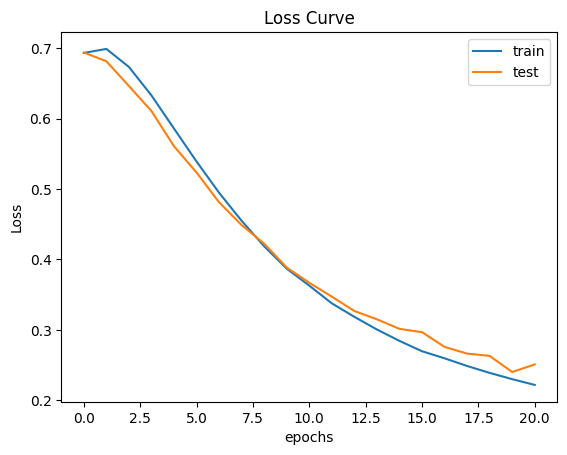

In [17]:
plt.plot(loss_train,label="train")
plt.plot(loss_test,label='test')
plt.title("Loss Curve")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

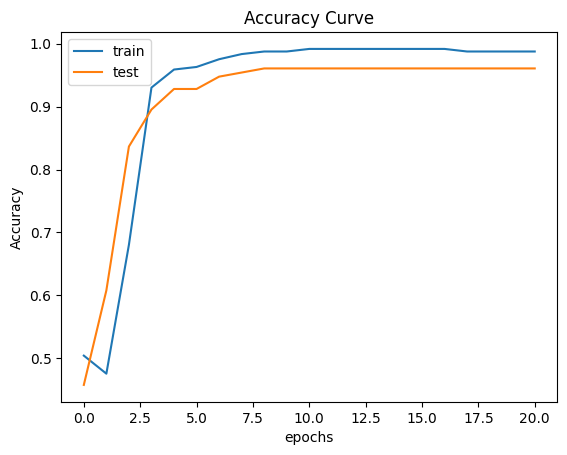

In [18]:
plt.plot(acc_train,label="train")
plt.plot(acc_test,label='test')
plt.title("Accuracy Curve")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visulaizing Predictions

In [37]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [38]:
def visualize_model(model, num_images=6,model_name='abc'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if model_name=='hmodel':
                tinputs = processor(timg.to(device), return_tensors="pt",do_rescale=False)
                outputs = model(**tinputs.to(device)).logits
            else:
                outputs = model(inputs)
                
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

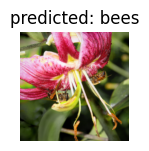

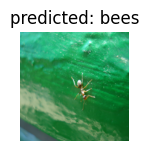

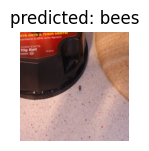

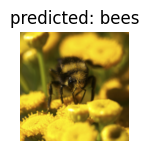

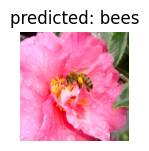

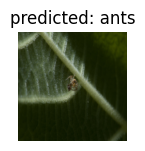

In [39]:
visualize_model(hmodel,model_name='hmodel')

plt.ioff()
plt.show()